## Tensorflow installation

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/Video CNN-LSTM'

/content/drive/MyDrive/Video CNN-LSTM


# Dataset Extraction

In [4]:
# Extract the file
!tar -xf ucf101_top5.tar.gz

# Imports

In [5]:
# Importing necessary libraries
import os  # Operating system library for file and directory operations

import keras
from imutils import paths  # Utility functions for working with image paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio  # Library for reading and writing image data
import cv2
from IPython.display import Image  # Displaying images in Jupyter notebooks


# Heyper-parameters

In [6]:
# Setting parameters for image processing and model training
IMAGE_DIMENSION = 600  # Target size for resizing images
BATCH_SIZE = 64
TRAINING_EPOCHS = 20

# Parameters for sequence processing in video frames
SEQUENCE_LENGTH = 20  # Maximum length of the sequence of frames in a video
FEATURE_VECTOR_SIZE = 2560  # Number of features to be extracted from each frame

# Data Preparation

In [7]:
# Loading training and testing datasets from CSV files
training_data = pd.read_csv("train.csv")  # DataFrame containing training data
testing_data = pd.read_csv("test.csv")  # DataFrame containing testing data

# Displaying the number of videos in each dataset
print(f"Total videos for training: {len(training_data)}")
print(f"Total videos for testing: {len(testing_data)}")

# Displaying a random sample of 10 entries from the training dataset
training_data.sample(10)


Total videos for training: 594
Total videos for testing: 224


,video_name,tag
243,v_Punch_g08_c06.avi,Punch
487,v_TennisSwing_g09_c05.avi,TennisSwing
255,v_Punch_g10_c04.avi,Punch
461,v_ShavingBeard_g23_c05.avi,ShavingBeard
460,v_ShavingBeard_g23_c04.avi,ShavingBeard
276,v_Punch_g13_c05.avi,Punch
73,v_CricketShot_g18_c05.avi,CricketShot
236,v_PlayingCello_g25_c06.avi,PlayingCello
17,v_CricketShot_g10_c04.avi,CricketShot
497,v_TennisSwing_g11_c01.avi,TennisSwing


In [8]:
# The following two methods are adapted from a TensorFlow tutorial on action recognition:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def center_crop_frame(input_frame):
    """
    Crop the center square of a given frame.

    Args:
    input_frame: The frame to be cropped.

    Returns:
    Cropped frame.
    """
    height, width = input_frame.shape[0:2]
    min_dimension = min(height, width)
    start_x = (width // 2) - (min_dimension // 2)
    start_y = (height // 2) - (min_dimension // 2)
    return input_frame[start_y : start_y + min_dimension, start_x : start_x + min_dimension]


def process_video(video_path, max_frame_count=0, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION)):
    """
    Load and process video from a given path.

    Args:
    video_path: Path to the video file.
    max_frame_count: Maximum number of frames to extract from the video.
    target_size: Size to resize each frame.

    Returns:
    Array of processed frames.
    """
    video_capture = cv2.VideoCapture(video_path)
    processed_frames = []
    try:
        while True:
            frame_captured, frame = video_capture.read()
            if not frame_captured:
                break
            frame = center_crop_frame(frame)
            frame = cv2.resize(frame, target_size)
            frame = frame[:, :, [2, 1, 0]]  # Reordering color channels
            processed_frames.append(frame)

            if len(processed_frames) == max_frame_count:
                break
    finally:
        video_capture.release()
    return np.array(processed_frames)


# CNN-based Feature Extractor

In [9]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB7


def create_feature_extraction_model():
    """
    Build a feature extraction model using InceptionV3 architecture.

    Returns:
    A Keras model for feature extraction.
    """
    # Initializing the InceptionV3 model with pre-trained ImageNet weights
    feature_extractor = EfficientNetB7(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
    )
    # Defining preprocessing function specific to InceptionV3
    preprocess_input = keras.applications.efficientnet.preprocess_input

    # Defining model inputs and preprocessing steps
    model_inputs = keras.Input((IMAGE_DIMENSION, IMAGE_DIMENSION, 3))
    preprocessed_inputs = preprocess_input(model_inputs)

    # Obtaining feature outputs from the InceptionV3 model
    model_outputs = feature_extractor(preprocessed_inputs)
    # Creating and returning the feature extraction model
    return keras.Model(model_inputs, model_outputs, name="feature_extraction_model")

# Initialize the feature extractor
feature_extraction_model = create_feature_extraction_model()

258076736/258076736 [==============================] - 2s 0us/step


# Label Processor

In [10]:
# Creating a label processor for converting string labels to numeric indices
tag_processor = keras.layers.StringLookup(
    num_oov_indices=0,  # Number of out-of-vocabulary indices
    vocabulary=np.unique(training_data["tag"])  # Unique tags from training data
)

# Displaying the vocabulary of the label processor
print(tag_processor.get_vocabulary())


['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [11]:
def process_videos_and_extract_features(dataframe, directory_path):
    """
    Prepare all videos in the given dataframe by extracting features and creating masks.

    Args:
    dataframe: DataFrame containing video information.
    directory_path: Root directory where videos are stored.

    Returns:
    Tuple of (features, masks) and labels for the videos.
    """
    total_samples = len(dataframe)
    video_file_paths = dataframe["video_name"].values.tolist()
    video_labels = dataframe["tag"].values
    video_labels = np.array(tag_processor(video_labels[..., None]))

    # Initializing arrays to store frame masks and features
    video_frame_masks = np.zeros(shape=(total_samples, SEQUENCE_LENGTH), dtype="bool")
    video_frame_features = np.zeros(
        shape=(total_samples, SEQUENCE_LENGTH, FEATURE_VECTOR_SIZE), dtype="float32"
    )

    # Processing each video
    for index, video_path in enumerate(video_file_paths):
        # Loading video frames
        frames = process_video(os.path.join(directory_path, video_path))
        frames = frames[None, ...]

        # Temporary arrays for current video's features and masks
        temp_mask = np.zeros(shape=(1, SEQUENCE_LENGTH), dtype="bool")
        temp_features = np.zeros(shape=(1, SEQUENCE_LENGTH, FEATURE_VECTOR_SIZE), dtype="float32")

        # Extracting features for each frame in the video
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(SEQUENCE_LENGTH, video_length)
            for j in range(length):
                temp_features[i, j, :] = feature_extraction_model.predict(
                    batch[None, j, :], verbose=0
                )
            temp_mask[i, :length] = 1  # Marking non-padded frames

        video_frame_features[index] = temp_features.squeeze()
        video_frame_masks[index] = temp_mask.squeeze()

    return (video_frame_features, video_frame_masks), video_labels


# Processing training and testing datasets
training_features, training_labels = process_videos_and_extract_features(training_data, "train")
testing_features, testing_labels = process_videos_and_extract_features(testing_data, "test")

# Displaying the shape of frame features and masks in the training set
print(f"Frame features in train set: {training_features[0].shape}")
print(f"Frame masks in train set: {training_features[1].shape}")

Frame features in train set: (594, 20, 2560)
Frame masks in train set: (594, 20)


# RNN using LSTM

In [12]:
from tensorflow.keras.layers import LSTM

def create_rnn_sequence_model():
    """
    Build and compile an RNN model for sequence processing.

    Returns:
    Compiled RNN model.
    """
    # Retrieving the vocabulary from the tag processor
    tag_vocabulary = tag_processor.get_vocabulary()

    # Defining input layers for frame features and mask
    frame_feature_input = keras.Input((SEQUENCE_LENGTH, FEATURE_VECTOR_SIZE))
    sequence_mask_input = keras.Input((SEQUENCE_LENGTH,), dtype="bool")

    # Building the LSTM layers
    lstm_layer = LSTM(16, return_sequences=True)(frame_feature_input, mask=sequence_mask_input)
    lstm_layer = LSTM(8)(lstm_layer)
    lstm_layer = keras.layers.Dropout(0.4)(lstm_layer)
    lstm_layer = keras.layers.Dense(8, activation="relu")(lstm_layer)

    # Defining the output layer
    output_layer = keras.layers.Dense(len(tag_vocabulary), activation="softmax")(lstm_layer)

    # Creating the RNN model
    sequence_model = keras.Model([frame_feature_input, sequence_mask_input], output_layer)

    # Compiling the model
    sequence_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return sequence_model


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Utility function for running model training and evaluation experiments.
def conduct_experiment():
    """
    Train the RNN sequence model and evaluate its performance.

    Returns:
    Training history and the trained sequence model.
    """
    # EarlyStopping callback
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
    # File path for saving the best model weights
    model_weights_filepath = "/tmp/video_classifier/ckpt.weights.h5"
    # ModelCheckpoint callback
    model_checkpoint_callback = ModelCheckpoint(
        model_weights_filepath, save_weights_only=True, save_best_only=True, verbose=1)

    # Creating and training the RNN sequence model
    rnn_sequence_model = create_rnn_sequence_model()
    training_history = rnn_sequence_model.fit(
        [training_features[0], training_features[1]],
        training_labels,
        validation_split=0.3,
        epochs=TRAINING_EPOCHS,
        callbacks=[model_checkpoint_callback],
    )

    # Loading the best weights and evaluating the model on the test set
    rnn_sequence_model.load_weights(model_weights_filepath)
    _, test_accuracy = rnn_sequence_model.evaluate([testing_features[0], testing_features[1]], testing_labels)
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

    return training_history, rnn_sequence_model


# Running the experiment and storing the sequence model
training_history, trained_sequence_model = conduct_experiment()

Epoch 1/20
 9/13 [===================>..........] - ETA: 0s - loss: 1.4562 - accuracy: 0.4410
Epoch 1: val_loss improved from inf to 1.45663, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 15s 319ms/step - loss: 1.4033 - accuracy: 0.4819 - val_loss: 1.4566 - val_accuracy: 0.1285
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 1.2115 - accuracy: 0.6578
Epoch 2: val_loss improved from 1.45663 to 1.42293, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 1s 43ms/step - loss: 1.2115 - accuracy: 0.6578 - val_loss: 1.4229 - val_accuracy: 0.0391
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.7060
Epoch 3: val_loss did not improve from 1.42293
13/13 [==============================] - 0s 32ms/step - loss: 1.1067 - accuracy: 0.7060 - val_loss: 1.4708 - val_accuracy: 0.0894
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 1.0

In [14]:
# Printing the model summary
trained_sequence_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 2560)]           0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 20, 16)               164928    ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 8)                    800       ['lstm[0][0]']            

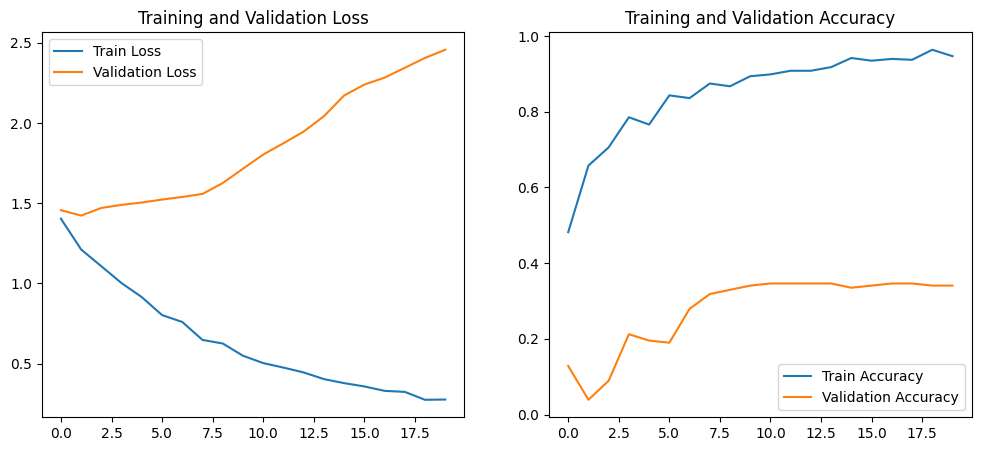

In [15]:
# Plotting function for training history
def plot_training_history(history):
    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Plotting the training history
plot_training_history(training_history)


7/7 [==============================] - 2s 7ms/step


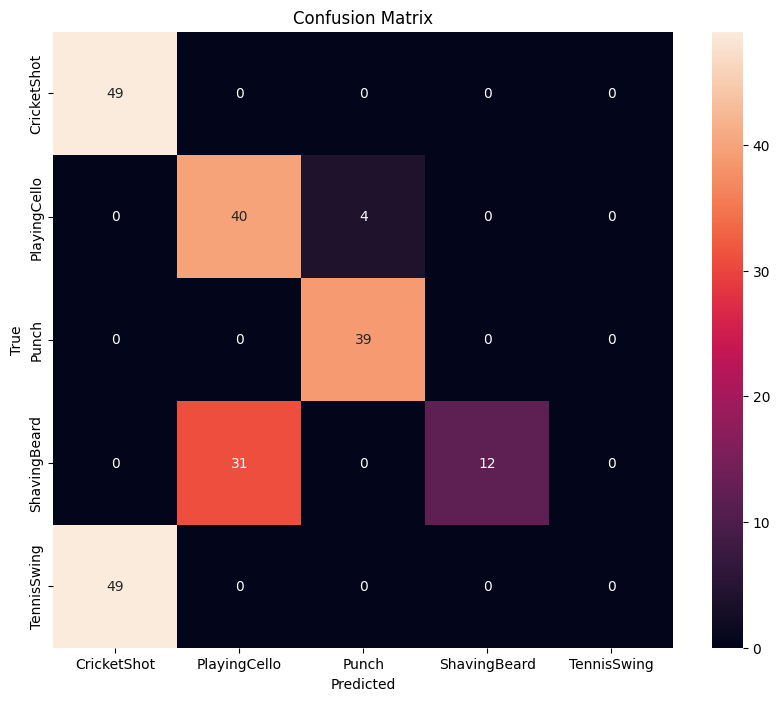

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model, features, labels):
    # Predicting on test data
    predictions = model.predict(features)
    predictions = np.argmax(predictions, axis=1)

    # Creating the confusion matrix
    cm = confusion_matrix(labels, predictions)
    cm_labels = tag_processor.get_vocabulary()

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plotting the confusion matrix
plot_confusion_matrix(trained_sequence_model, [testing_features[0], testing_features[1]], testing_labels)


# Inference

Test video path: v_TennisSwing_g02_c04.avi
1/1 [==============================] - 2s 2s/step
  CricketShot: 31.33%
  Punch: 27.81%
  TennisSwing: 24.62%
  ShavingBeard:  9.71%
  PlayingCello:  6.53%


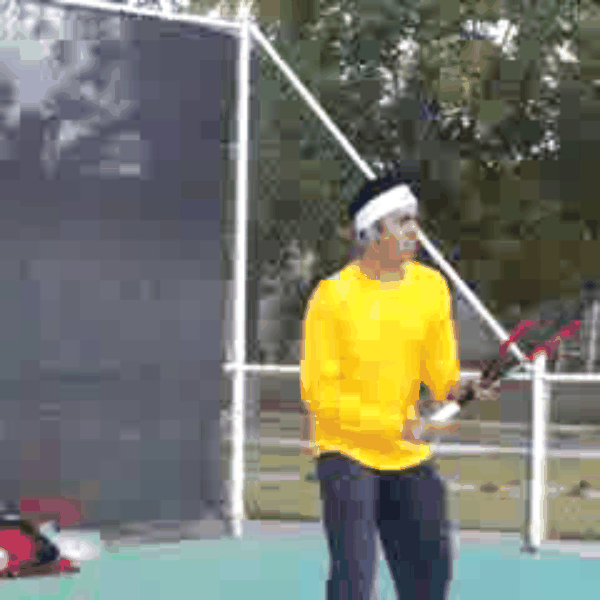

In [17]:
def prepare_video_for_prediction(video_frames):
    """
    Prepare a single video's frames for prediction by the sequence model.

    Args:
    video_frames: Frames of the video to be processed.

    Returns:
    Tuple of processed frame features and frame mask.
    """
    video_frames = video_frames[None, ...]
    single_frame_mask = np.zeros(shape=(1, SEQUENCE_LENGTH), dtype="bool")
    single_frame_features = np.zeros(shape=(1, SEQUENCE_LENGTH, FEATURE_VECTOR_SIZE), dtype="float32")

    for i, batch in enumerate(video_frames):
        frame_count = batch.shape[0]
        effective_length = min(SEQUENCE_LENGTH, frame_count)
        for j in range(effective_length):
            single_frame_features[i, j, :] = feature_extraction_model.predict(batch[None, j, :])
        single_frame_mask[i, :effective_length] = 1  # Marking non-padded frames

    return single_frame_features, single_frame_mask


def predict_video_sequence(video_path):
    """
    Perform sequence prediction on a given video.

    Args:
    video_path: Path to the video file.

    Returns:
    Frames of the video.
    """
    tag_vocabulary = tag_processor.get_vocabulary()

    video_frames = process_video(os.path.join("test", video_path))
    frame_features, frame_mask = prepare_video_for_prediction(video_frames)
    prediction_probabilities = trained_sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(prediction_probabilities)[::-1]:
        print(f"  {tag_vocabulary[i]}: {prediction_probabilities[i] * 100:5.2f}%")
    return video_frames


# Utility function to convert video frames to a GIF for visualization
def frames_to_gif(video_frames):
    """
    Convert a sequence of video frames to a GIF.

    Args:
    video_frames: Frames of the video.

    Returns:
    IPython Image display object of the created GIF.
    """
    processed_frames = video_frames.astype(np.uint8)
    imageio.mimsave("animation.gif", processed_frames, duration=100)
    return Image("animation.gif")


# Selecting a random test video and performing prediction
random_test_video = np.random.choice(testing_data["video_name"].values.tolist())
print(f"Test video path: {random_test_video}")
predicted_test_frames = predict_video_sequence(random_test_video)
frames_to_gif(predicted_test_frames[:SEQUENCE_LENGTH])
